# Load and Inspect Online Forecast Dataset

This notebook demonstrates how to load and inspect a forecast dataset using the NeuralHydrology config.

In [1]:
import os
os.getcwd()

'/home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/operational_harz/gefs_10d_sample'

In [2]:
os.chdir('../../')

In [4]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta
from pathlib import Path
from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo.onlineforecastdataset import OnlineForecastDataset

## Load Configuration

First, let's load the configuration file and examine the key settings.

In [5]:
# Load the config file
config_path = Path('operational_harz/gefs_10d_sample/config.yml')
config = Config(config_path)

## Create Forecast Dataset

Now let's create a ForecastDataset instance and examine its properties.

In [6]:
# Initialize the dataset
dataset = OnlineForecastDataset(cfg=config, is_train=True, period='train')

100%|██████████| 2/2 [01:13<00:00, 36.68s/it]


## Inspect Available Variables

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import dates as mdates

# 1. Efficiently display all variables
# The OnlineForecastDataset manages an xarray Dataset internally. 
# We can access or reconstruct it using the protected method _load_or_create_xarray_dataset()
# which handles the merging of historical and forecast data.
xr_dataset = dataset._load_or_create_xarray_dataset()

print("Xarray Dataset Structure:")
print(xr_dataset)

Xarray Dataset Structure:
<xarray.Dataset> Size: 83MB
Dimensions:                     (basin: 2, time: 32112, issue_time: 1308,
                                 lead_time: 240)
Coordinates:
  * lead_time                   (lead_time) timedelta64[ns] 2kB 01:00:00 ... ...
    latitude                    float64 8B 51.75
  * basin                       (basin) object 16B 'DE2' 'DE4'
    expected_forecast_length    (issue_time) timedelta64[ns] 10kB 35 days ......
    spatial_ref                 int64 8B 0
  * issue_time                  (issue_time) datetime64[ns] 10kB 2020-10-01 ....
    longitude                   float64 8B 10.5
  * time                        (time) datetime64[ns] 257kB 2020-09-01 ... 20...
Data variables: (12/29)
    shortwave_radiation         (basin, time) float64 514kB dask.array<chunksize=(1, 32112), meta=np.ndarray>
    temperature_2m_q75          (basin, issue_time, lead_time) float64 5MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    et0_fao_evapotransp

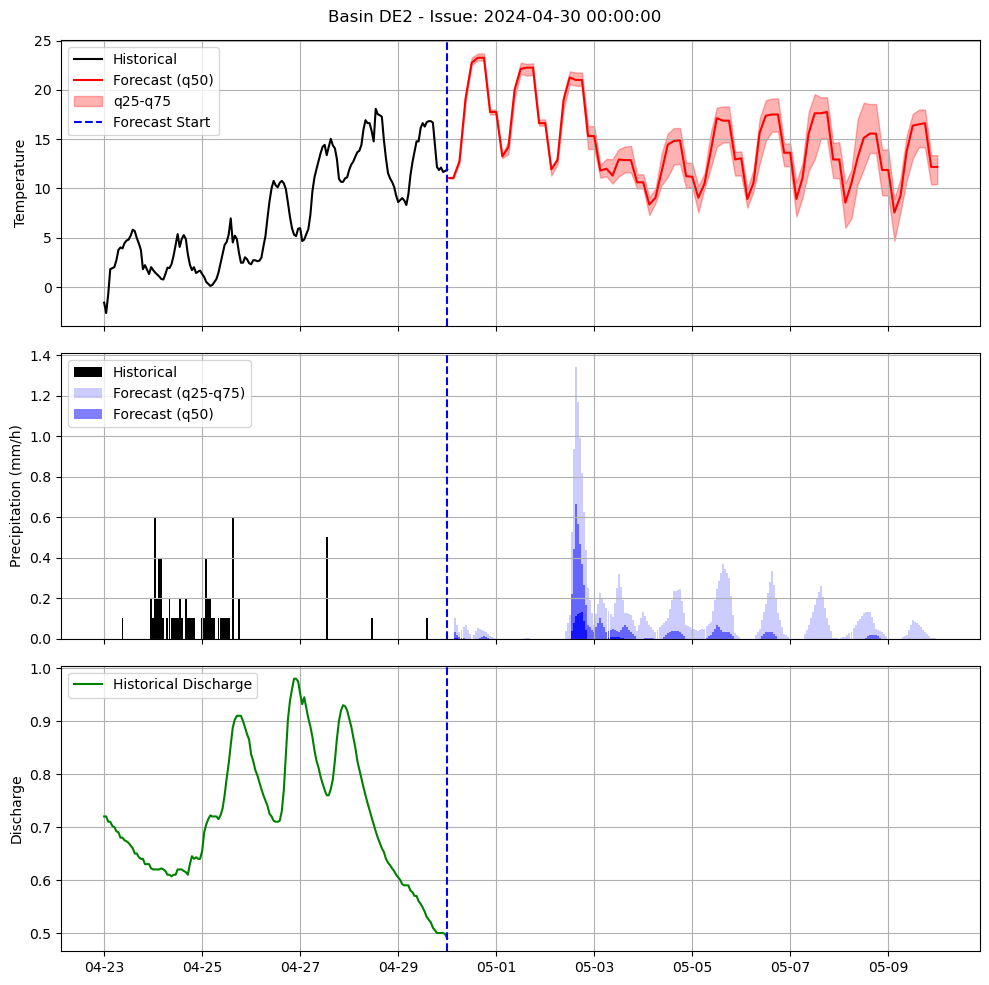

In [22]:
# 2. Plot example variables
if 'basin' in xr_dataset.coords and xr_dataset['basin'].size > 0:
    basin_id = str(xr_dataset['basin'].values[0])
    ds = xr_dataset.sel(basin=basin_id)
    
    # Helper to find variables
    def get_var(keywords, dims_req, dims_exc=[], suffix=''):
        return next((v for v in xr_dataset.data_vars 
                     if any(k in v for k in keywords) and v.endswith(suffix)
                     and all(d in xr_dataset[v].dims for d in dims_req)
                     and not any(d in xr_dataset[v].dims for d in dims_exc)), None)

    # Identify variables
    h_vars = {
        'temp': get_var(['temperature'], ['time'], ['lead_time']),
        'prec': get_var(['precipitation'], ['time'], ['lead_time']),
        'q': get_var(['discharge', 'q_'], ['time'], ['lead_time'])
    }
    
    # Find forecast base names via q50
    f_vars = {}
    for k, kws in [('temp', ['temperature_2m', 'temperature']), ('prec', ['total_precipitation', 'precipitation'])]:
        q50 = get_var(kws, ['issue_time', 'lead_time'], suffix='_q50')
        if q50 and 'dewpoint' not in q50:
            base = q50.replace('_q50', '')
            f_vars[k] = [f"{base}_{q}" for q in ['q25', 'q50', 'q75']]

    if all(h_vars.values()) and len(f_vars) == 2:
        # Data extraction
        last_issue = ds['issue_time'].values[-1]
        last_issue_dt = pd.to_datetime(last_issue)
        hist_slice = slice(last_issue_dt - pd.Timedelta(days=7), last_issue_dt)
        
        h_data = {k: ds[v].sel(time=hist_slice).to_series() for k, v in h_vars.items()}
        f_dates = last_issue_dt + pd.to_timedelta(ds['lead_time'].values)
        
        # Extract forecast quantiles (fallback to q50 if missing)
        f_data = {k: [ds[v].sel(issue_time=last_issue).values if v in ds else ds[vs[1]].sel(issue_time=last_issue).values 
                      for v in vs] for k, vs in f_vars.items()}

        # Plotting
        fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        
        # Temperature
        axes[0].plot(h_data['temp'].index, h_data['temp'], 'k-', label='Historical')
        axes[0].plot(f_dates, f_data['temp'][1], 'r-', label='Forecast (q50)')
        axes[0].fill_between(f_dates, f_data['temp'][0], f_data['temp'][2], color='red', alpha=0.3, label='q25-q75')
        axes[0].set_ylabel('Temperature')
        
        # Precipitation (mm/s -> mm/h)
        axes[1].bar(h_data['prec'].index, h_data['prec'], width=0.04, color='k', label='Historical')
        for i, alpha in zip([2, 1, 0], [0.2, 0.5, 0.8]): # Plot q75, q50, q25
            lbl = 'Forecast (q25-q75)' if i==2 else ('Forecast (q50)' if i==1 else "")
            axes[1].bar(f_dates, f_data['prec'][i] * 3600.0, width=0.04, color='b', alpha=alpha, label=lbl)
        axes[1].set_ylabel('Precipitation (mm/h)')
        
        # Discharge
        axes[2].plot(h_data['q'].index, h_data['q'], 'g-', label='Historical Discharge')
        axes[2].set_ylabel('Discharge')
        
        for ax in axes:
            ax.axvline(last_issue_dt, color='b', linestyle='--', label='Forecast Start' if ax==axes[0] else "")
            ax.legend(loc='upper left')
            ax.grid(True)
            
        axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.suptitle(f"Basin {basin_id} - Issue: {last_issue_dt}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Missing variables. Found: Hist={h_vars}, Fcst={f_vars.keys()}")
else:
    print("No basin information found.")